### Requirements
- For a Q500US universe of securities (Quantopian provides tools to
construct different security universes and Q500US is one of them), as of
1/3/2017
- Calculate the mean and median 5-minute volume buckets for each
security in the Q500US universe, for the month of January, First bucket would be 9:31 - 9:35, and so on
- For 5 randomly chosen securities from the Q500US universe, plot
the intraday bars for each 5-minute volume bucket
- Convert the 5-minute median volume measures to percent, For each 5-minute metric for a security, divide that bucket by the sum of all 5-minute medians for that security over the day, then multiply by 100. So, the metric for each bucket would now be in the (0,100) range and the sum of all 5-minute buckets for a security should add up to 100
- For the same 5 randomly chosen securities, now plot the intraday bars for each 5-minute percent volume bucket
- Group securities into 4 quantiles of liquidity as follows:For each security, get the median daily volume for the month of January
- Least liquid securities (by number of shares traded), will get the lower percentile ranks and most liquid securities will get the higher percentile ranks
- For each quantile, calculate a mean of 5-minute percent volume buckets, by simply averaging it over all the securities in that quantile
- Plot the 5-minute volume percent buckets for each quantile

In [2]:
from quantopian.pipeline.filters import Q500US
import copy
import numpy as np    
import pandas as pd
from zipline.api import attach_pipeline, pipeline_output
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from numpy import median
import random
import matplotlib.pyplot as plt
import operator
from itertools import groupby
import datetime as dt
# from matplotlib.finance import candlestick

In [3]:
# Make some definitions
start = '2017-01-03'
end = '2017-01-31'

In [4]:
def MedianValue(data, length):
    med = []
    for i in np.arange(0,len(data),length): 
        med.append(np.median(data[i:i+length-1]))
    return med

def MeanValue(data, length):
    mean = []
    for i in np.arange(0,len(data),length): 
        mean.append(np.mean(data[i:i+length-1]))
    return mean    

def Percentage(data):
    percentage = []
    for i in data:
        percentage.append(i/sum(data)*100) 
    return percentage

#### For a Q500US universe of securities (Quantopian provides tools to construct different security universes and Q500US is one of them), as of 1/3/2017

In [5]:
# access data from Q500US on 1/3/2017
pipe = Pipeline(screen = Q500US())  
equity = run_pipeline(pipe, start, start)
syms = equity.index.values
equity.head()

Empty DataFrame
Columns: []
Index: [(2017-01-03 00:00:00+00:00, Equity(24 [AAPL])), (2017-01-03 00:00:00+00:00, Equity(62 [ABT])), (2017-01-03 00:00:00+00:00, Equity(67 [ADSK])), (2017-01-03 00:00:00+00:00, Equity(76 [TAP])), (2017-01-03 00:00:00+00:00, Equity(114 [ADBE]))]

#### Calculate the mean and median 5-minute volume buckets for each security in the Q500US universe, for the month of January, First bucket would be 9:31 - 9:35, and so on

In [6]:
# Input: each asset, frequency('daily','minute'), start date, end date
# Output: volume(list)
def get_volume_5m_mean(syms,start,end):
    volume_1m = get_pricing(syms, start_date=start, end_date=end,
                                frequency='minute', fields='volume') 
    mean_volume_5m = MeanValue(volume_1m, 5)
    return mean_volume_5m
#     print(mean_volume_5m)

def get_volume_5m_med(syms,start,end):
    volume_1m = get_pricing(syms, start_date=start, end_date=end,
                                frequency='minute', fields='volume') 
    median_volume_5m = MedianValue(volume_1m, 5)
    return median_volume_5m

In [ ]:
for i in range(500):
    sym_unit = syms[i][1].symbol
    volume_5m_mean = get_volume_5m_mean(sym_unit,start,end)
    volume_5m_med = get_volume_5m_med(sym_unit,start,end)
    print(i)

#### For 5 randomly chosen securities from the Q500US universe, plot the intraday bars for each 5-minute volume bucket. Convert the 5-minute median volume measures to percent, plot the intraday bars for each 5-minute percent volume bucket

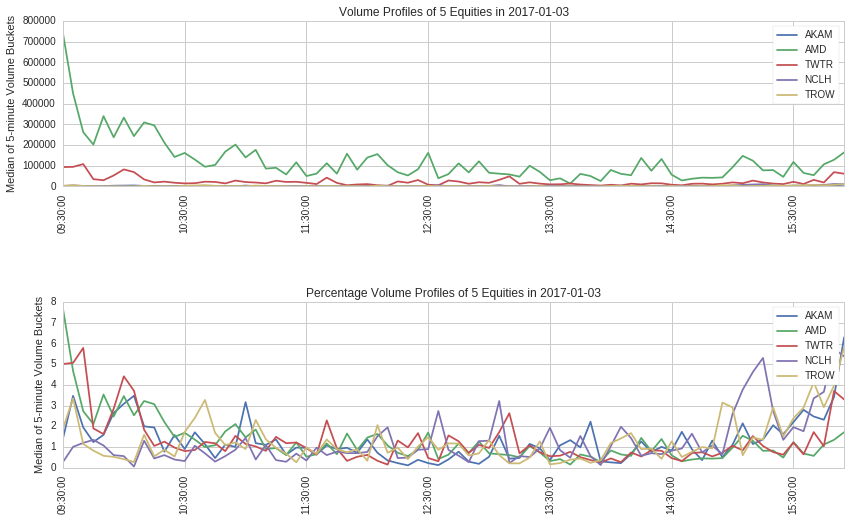

In [7]:
# Set '2017-01-03' as the trading day
intradate = '2017-01-03' 
# randomly select 5 equities in Q500US
ind = random.sample(np.arange(1,500),5)
sys_name = []
# for each equity, plot bars for intraday 5m volume buckets
for i in ind:
    sym_rand = syms[i][1].symbol
    sys_name.append(sym_rand)
    vol_rand_5m_med = get_volume_5m_med(sym_rand,intradate,intradate)
    vol_rand_5m_med_percentage = Percentage(vol_rand_5m_med)
    n = len(vol_rand_5m_med_percentage)
    
    plt.subplot(2, 1, 1)
    plt.plot(vol_rand_5m_med)
    x = range(0,len(vol_rand_5m_med),12)
    t = []
    for i in range(9,16,1):
        t.append(str(dt.time(i,30,0)))
    plt.xticks(x,t,rotation='vertical')
    plt.ylabel('Median of 5-minute Volume Buckets')
    plt.title('Volume Profiles of 5 Equities in 2017-01-03')
    plt.legend(sys_name)
    
    plt.subplot(2, 1, 2)
    plt.plot(vol_rand_5m_med_percentage)
    plt.xticks(x,t,rotation='vertical')
    plt.ylabel('Median of 5-minute Volume Buckets')
    plt.title('Percentage Volume Profiles of 5 Equities in 2017-01-03')
    plt.legend(sys_name)
    
    plt.subplots_adjust(hspace=0.7)


    

#### Group securities into 4 quantiles of liquidity as follows:For each security, get the median daily volume for the month of January. Least liquid securities (by number of shares traded), will get the lower percentile ranks and most liquid securities will get the higher percentile ranks. 

In [8]:
sym_names = []
equity_500_volume = []
volume_1m_list = []
for i in range(44): # I choose 44 equities instead of 500 to reduce computational cost
    sym_unit = syms[i][1].symbol
    sym_names.append(sym_unit)
    volume_1d = get_pricing(sym_unit, start_date=start, end_date=end,frequency='daily', fields='volume')
    volume_1m_list.append(np.median(volume_1d))
    print(i)
    
# make a dictionary of each equity & corresponding volumes    
equity_500_volume = dict(zip(sym_names, volume_1m_list)) 
equity_sorted_sym = [row[0] for row in sorted(equity_500_volume.items(),
                                              key=operator.itemgetter(1),reverse=True)]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


#### For each quantile, calculate a mean of 5-minute percent volume buckets, by simply averaging it over all the securities in that quantile. Plot the 5-minute volume percent buckets for each quantile

[u'BAC', u'AMD', u'AAPL', u'C', u'BMY', u'ABT', u'AMAT', u'BSX', u'BK', u'AIG', u'AXP']
[u'CAT', u'BBY', u'TWX', u'HES', u'APC', u'ADM', u'AET', u'AMGN', u'BA', u'APA', u'CAG']
[u'BAX', u'CA', u'ADBE', u'AFL', u'BEN', u'CAH', u'AEP', u'BHI', u'ADI', u'BBBY', u'ADSK']
[u'CCE', u'ADP', u'AME', u'ALK', u'APD', u'TAP', u'BDX', u'AON', u'BLL', u'BCR', u'AZO']


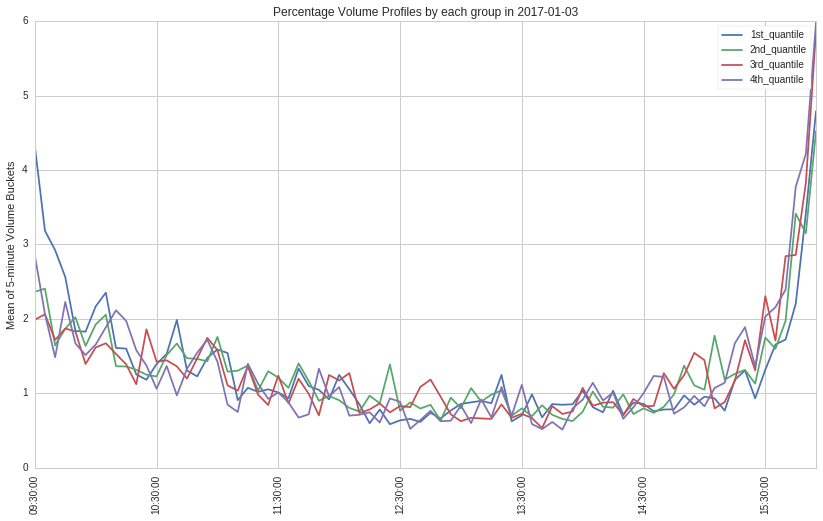

In [9]:
for i in range(4):
    group_num = len(equity_sorted_sym)/4
    group = equity_sorted_sym[i*group_num:(i+1)*group_num]
    print(group) # equity name in each group
    total = [0]*n
    for sym in group:
        volume_5m_group = get_volume_5m_med(sym,start,start)
        volume_5m_group_percentage = Percentage(volume_5m_group)
        total=[sum(x) for x in zip(total, volume_5m_group_percentage)]
    volume_5m_group_percentage_avg = [x / group_num for x in total]  
    
# I choose one day(2017-01-03) for visualization
    plt.plot(volume_5m_group_percentage_avg)
    x = range(0,len(volume_5m_group_percentage),12)
    t = []
    for i in range(9,16,1):
        t.append(str(dt.time(i,30,0)))
    plt.xticks(x,t,rotation='vertical')
    plt.ylabel('Mean of 5-minute Volume Buckets')
    plt.title('Percentage Volume Profiles by each group in 2017-01-03')
    plt.legend(['1st_quantile','2nd_quantile','3rd_quantile','4th_quantile'])